In [1]:
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices()
import sklearn
from tsai.basics import *
my_setup(sklearn)
from matplotlib import dates as mdates
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
import papermill as pm

os              : Linux-6.8.0-39-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


# Forecast SolAP

> 6- day horizon, hourly based

In [2]:
cwd = os.getcwd()
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_geo = yaml2dict('./config/geoap.yaml', attrdict=True)
config_train = config_geo.train
config_data = config_geo.data

# Merge the two configs (the second one overrides the first one for any keys that are present in both)
config = AttrDict({**config_base,
                   **config_train, 
                   "data":AttrDict({**config_data})})

# Add the architecture config
if config.arch_config_file is not None:
    config.arch_config_file = Path(config.arch_config_file)
    if config.arch_config_file.exists():
        config.arch = yaml2dict(config.arch_config_file, attrdict=True)
    else:
        print(f'No custom arch config found in {config.arch_config_file}')
        config.arch = AttrDict()
else:
    config.arch = AttrDict()

In [3]:
run = wandb.init(project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config
config

```json
{ 'add_time_channels': False,
  'arch': {'attn_dropout': 0.4, 'd_model': 1024, 'dropout': 0.2, 'n_heads': 32},
  'arch_config_file': Path('config/patchtst.yaml'),
  'arch_name': 'PatchTST',
  'bs': 64,
  'data': { 'data_nb': './geoap_data.ipynb',
            'data_path': '../data/SOLAP.TXT',
            'data_url': 'https://www-app3.gfz-potsdam.de/kp_index/Kp_ap_since_1932.txt',
            'df_save_path': './preprocessed_data/dataframes/geoap.pkl',
            'force_download': False,
            'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_geoap.pkl'},
  'deltaHL': 4.0,
  'horizon': 48,
  'init_weights': False,
  'is_optuna_study': False,
  'lookback': 144,
  'lr_max': None,
  'n_epoch': 50,
  'partial_n': 0.001,
  'seed': 42,
  'test_end_datetime': '2018-12-31 12:00:00',
  'test_start_datetime': '2012-10-01 12:00:00',
  'valid_start_datetime': '2018-01-01 12:00:00',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

In [4]:
df, preproc_pipe = generate_preprocessed_data(config.data)

df.head()

,hh._m,days,AP,Datetime
0,1.5,0.000,18,1932-01-01 00:00:00
1,4.5,0.125,12,1932-01-01 03:00:00
2,7.5,0.250,9,1932-01-01 06:00:00
3,10.5,0.375,12,1932-01-01 09:00:00
4,13.5,0.500,18,1932-01-01 12:00:00


# Train

In [5]:
# In the paper by Licata et al. (2020) (https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496),
# authors use a period from October 2012 through the end of 2018 for the benchmarking.
# Therefore, we will set the test set as the same period for our analysis, 
# using the column Date as the timestamp, from October 2012 to the end of 2018. 
# Everything before the test set will be used for training, and everything after the test set
# will be used for validation
test_start_datetime = config.test_start_datetime
test_end_datetime = config.test_end_datetime
valid_start_datetime = config.valid_start_datetime

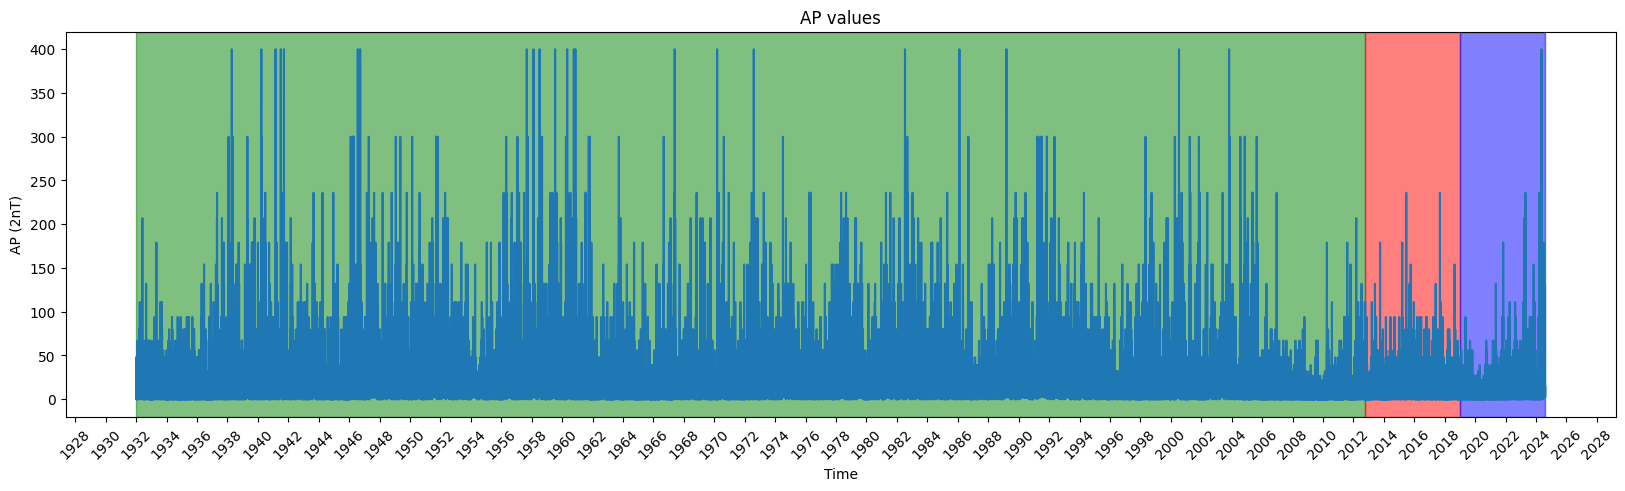

In [6]:
# hide

# Plot the variable AP, covering the different periods (training, test and validation)
# with different colors.
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df.Datetime, df.AP)
ax.axvspan(df.Datetime.min(), test_start_datetime, alpha=0.5, color='green')
ax.axvspan(test_start_datetime, test_end_datetime, alpha=0.5, color='red')
ax.axvspan(test_end_datetime, df.Datetime.max(), alpha=0.5, color='blue')
ax.set_title('AP values')
ax.set_xlabel('Time')
ax.set_ylabel('AP (2nT)')
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.show()

In [7]:
# Splits: same as in solar flux (solfsmy) notebook

splits_ = get_forecasting_splits(df[df.Datetime < valid_start_datetime], 
                             fcst_history=config.lookback, 
                             fcst_horizon=config.horizon, 
                             use_index=False, 
                             test_cutoff_datetime=test_start_datetime, 
                             show_plot=False, 
                             datetime_col='Datetime')
foo = df[df.Datetime >= valid_start_datetime]
bar = get_forecasting_splits(foo, config.lookback, config.horizon, valid_size=0.0, 
                             test_size=0.0, show_plot=False)
val_idxs = L(foo.index[bar[0]].tolist())

splits = (splits_[0], val_idxs, splits_[1])
splits

((#235766) [0,1,2,3,4,5,6,7,8,9...],
 (#19101) [251300,251301,251302,251303,251304,251305,251306,251307,251308,251309...],
 (#15296) [235813,235814,235815,235816,235817,235818,235819,235820,235821,235822...])

In [8]:
# Add or not add the time features
data_columns_fcst = ['AP']
data_columns_time = ['DOY']
data_columns = data_columns_fcst + data_columns_time if config.add_time_channels else data_columns_fcst
data_columns

['AP']

In [9]:
# Now that we have defined the splits for this particular experiment, we'll scale
# the data
train_split = splits[0]
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=data_columns)),
], verbose=True)
save_object(exp_pipe, 'tmp/exp_pipe.pkl')
exp_pipe = load_object('tmp/exp_pipe.pkl')
# TODO: I don't know why but if I don't copy the dataframe df it gets modified
df_scaled = exp_pipe.fit_transform(df.copy(), scaler__idxs = train_split)
#df_scaled.set_index(datetime_col, inplace=True)
df_scaled.head()

tmp directory already exists.
Pipeline saved as tmp/exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,hh._m,days,AP,Datetime
0,1.5,0.000,0.195079,1932-01-01 00:00:00
1,4.5,0.125,-0.097897,1932-01-01 03:00:00
2,7.5,0.250,-0.244384,1932-01-01 06:00:00
3,10.5,0.375,-0.097897,1932-01-01 09:00:00
4,13.5,0.500,0.195079,1932-01-01 12:00:00


In [10]:
# We'll approach the time series forecasting task as a supervised learning problem. 
# Remember that tsai requires that both inputs and outputs have the following shape:
# (samples, features, steps)

# To get those inputs and outputs we're going to use a function called 
# `prepare_forecasting_data`` that applies a sliding window along the dataframe
X, y = prepare_forecasting_data(df, fcst_history=config.lookback, fcst_horizon=config.horizon, 
                                x_vars=data_columns, y_vars=data_columns_fcst)
X = X.astype(float)
y = y.astype(float)
X.shape, y.shape

((270401, 1, 144), (270401, 1, 48))

### Train

In [ ]:
wandb_callback = WandbCallback(log_preds=False)
cbs = L(wandb_callback) if config.wandb.enabled else L()
learn = TSForecaster(X, y, splits=splits, batch_size=config.bs, 
                     pipelines=[preproc_pipe, exp_pipe], arch=config.arch_name, 
                     arch_config=dict(config.arch), 
                     init=config.init_weights,
                     cbs= cbs + ShowGraphCallback(), 
                     partial_n=config.partial_n)
learn.dls[0].partial_n, learn.dls[1].partial_n, learn.dls[2].partial_n
lr_max = learn.lr_find().valley if config.lr_max is None else config.lr_max
print(lr_max)
print(f"#params: {sum(p.numel() for p in learn.model.parameters())}")
learn.fit_one_cycle(n_epoch=config.n_epoch, lr_max=config.lr_max)

In [ ]:
# Print the validation loss and save it in case other notebooks (optuna) wants to
# use it for hyperparameter optimization
valid_loss = learn.validate()[0] 
print(valid_loss)
%store valid_loss

192.3565673828125
Stored 'valid_loss' (float)


In [ ]:
# Log the test loss to wandb
test_loss = learn.validate(ds_idx=2)[0]
print(test_loss)
if run is not None:
    run.log(dict(test_loss=test_loss))

211.60606384277344


In [ ]:
# Save everything
# learn.dls.loaders += [learn.dls.valid.new_dl(X[splits[2]], y[splits[2]])] # Add test datalaoder
# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learn.remove_cb(wandb_callback)

# Save locally and in wandb if online and enabled
learn.save_all(path='tmp', verbose=True) 
if run is not None and config.wandb_mode and config.wandb_log_learner:
    # Save the learner (all tmp/dls, tmp/model.pth, and tmp/learner.pkl). 
    run.log_artifact('tmp', type='learner', name='AP')

# Save the best model
model = {}
model['models'] = [learn.model]
model['lookback'] = config.lookback
model['horizon'] = config.horizon
model['data_columns'] = data_columns

torch.save(model, 'models/best/best_model_geoap.pth')
    

Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth']'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'


In [ ]:
if run is not None:
    run.finish()